# MNIST Rakam Sınıflandırma Projesi

Bu projede, MNIST veri seti üzerinde derin öğrenme tabanlı bir rakam sınıflandırma modeli geliştiriyorum. Modelin mimarisi, hiperparametre seçimleri ve sonuçlar detaylı şekilde açıklanmıştır.

## 1. Giriş ve Veri Seti Yükleme

MNIST veri seti, 0-9 arası el yazısı rakamları içeren 28x28 boyutunda 70,000 gri tonlamalı imgeden oluşur. Veri setini yükleyerek başlıyoruz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

In [2]:
# Veri setini yükleme
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## 2. Veri Keşfi ve Görselleştirme

Veri setinin boyutlarını inceleyerek ve örnek görselleri görselleştirerek başlıyoruz.

In [3]:
print("Eğitim görselleri boyutu:", train_images.shape)
print("Eğitim etiketleri boyutu:", train_labels.shape)
print("Test görselleri boyutu:", test_images.shape)
print("Test etiketleri boyutu:", test_labels.shape)

Eğitim görselleri boyutu: (60000, 28, 28)
Eğitim etiketleri boyutu: (60000,)
Test görselleri boyutu: (10000, 28, 28)
Test etiketleri boyutu: (10000,)


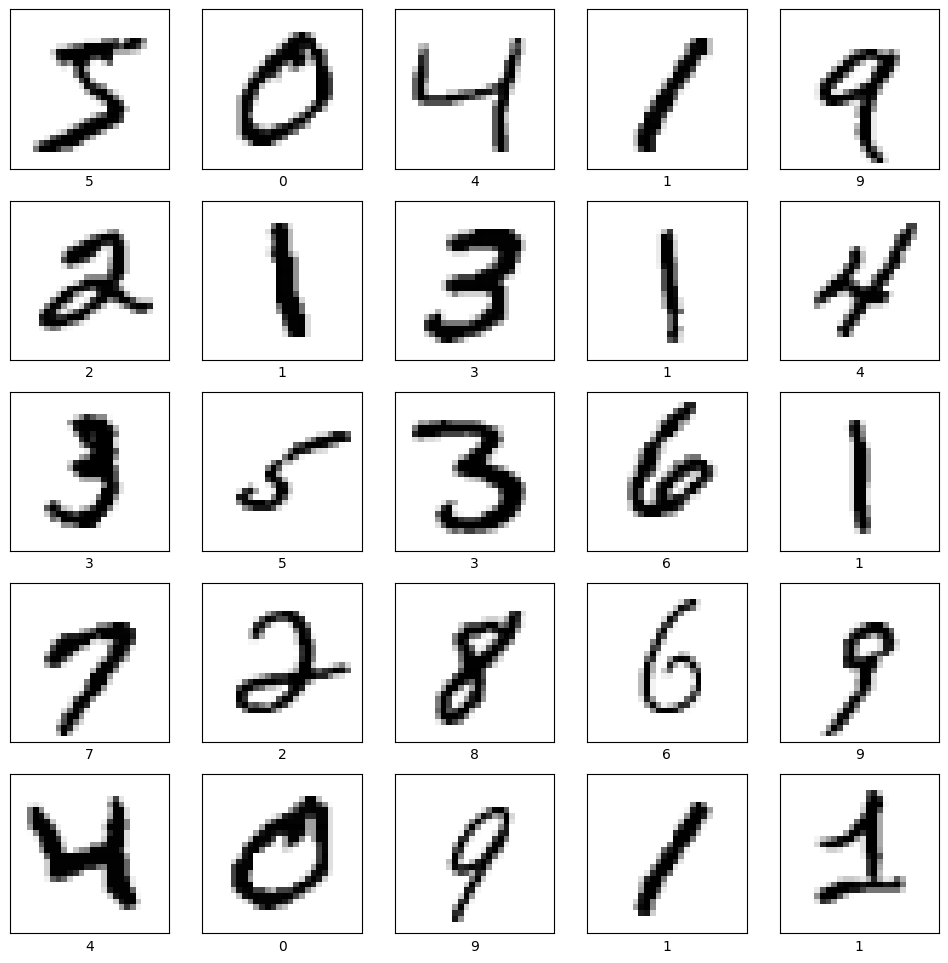

In [4]:
# Örnek 25 görseli görselleştirme
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(str(train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## 3. Veri Ön İşleme

Modelimiz için veriyi uygun forma getiriyoruz:
- Görselleri 28x28'den 784 boyutlu vektöre dönüştürme
- Piksel değerlerini [0,255] aralığından [0,1] aralığına normalize etme
- Etiketleri one-hot encoding formatına çevirme

In [5]:
# Veri ön işleme
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

## 4. Model Mimarisi

Modelimiz 4 katmandan oluşan bir Yapay Sinir Ağı (YSA):

1. **Giriş Katmanı**: 512 nöronlu, ReLU aktivasyonlu
2. **Gizli Katman 1**: 256 nöronlu, ReLU aktivasyonlu
3. **Gizli Katman 2**: 128 nöronlu, ReLU aktivasyonlu
4. **Çıkış Katmanı**: 10 nöronlu (sınıf sayısı), Softmax aktivasyonlu

### Katman Seçimlerinin Gerekçeleri:

- **ReLU Aktivasyonu**:
  - Hesaplama açısından verimli (türevi basit)
  - Gradyan kaybını (vanishing gradient) azaltır
  - Negatif değerleri sıfırlayarak öğrenmeyi hızlandırır

- **Nöron Sayıları (512 → 256 → 128)**:
  - Yüksek boyutlu özelliklerden başlayarak giderek azaltıyoruz
  - Bu yaklaşım, özellik çıkarımını kademeli olarak öğrenmeyi sağlar
  - 4 katman seçimimiz, modelin yeterince karmaşık olmasını sağlarken aşırı uyumu da kontrol edebilir

- **Softmax Çıkış Katmanı**:
  - Çok sınıflı sınıflandırma problemleri için ideal
  - Çıkışları olasılık dağılımına dönüştürür

In [6]:
# Model oluşturma
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(28*28,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Model özeti
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Derleme

Modeli RMSprop optimizer ile derliyoruz.

### Optimizasyon Seçimleri:

- **Optimizer**: RMSprop
  - Öğrenme oranını otomatik ayarlar
  - MNIST gibi problemlerde iyi performans gösterir
  - Gradyan dalgalanmalarını azaltır

- **Loss Fonksiyonu**: Categorical Crossentropy
  - Çok sınıflı sınıflandırma için uygun
  - Model çıktıları ile gerçek etiketler arasındaki farkı ölçer

- **Metrik**: Accuracy
  - Basit ve yorumlanması kolay bir metrik
  - Doğru sınıflandırma oranını gösterir

In [7]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 6. Model Eğitimi

Modeli 15 epoch boyunca, 128'lik batch size ile eğitiyoruz.

### Eğitim Parametreleri:

- **Batch Size = 128**:
  - Bellek kullanımı ve öğrenme istikrarı arasında iyi denge
  - 32-256 arası genellikle iyi sonuç verir
  - Çok küçük batch'ler gürültülü, çok büyük batch'ler yavaş öğrenir

- **Epoch Sayısı = 15**:
  - Erken durdurma (early stopping) kullanmadığımız için
  - Doğrulama kaybının stabilize olduğu noktaya kadar eğitim
  - Aşırı uyumu gözlemlemek için yeterli süre

- **Validation Split = 0.2**:
  - Eğitim verisinin %20'sini doğrulama için ayırıyoruz
  - Modelin genelleme performansını gözlemlemek için

In [8]:
history = model.fit(train_images, train_labels,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8423 - loss: 0.4996 - val_accuracy: 0.9633 - val_loss: 0.1203
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9675 - loss: 0.1061 - val_accuracy: 0.9622 - val_loss: 0.1201
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9809 - loss: 0.0635 - val_accuracy: 0.9767 - val_loss: 0.0864
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9861 - loss: 0.0442 - val_accuracy: 0.9743 - val_loss: 0.0859
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9901 - loss: 0.0313 - val_accuracy: 0.9689 - val_loss: 0.1193
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9937 - loss: 0.0222 - val_accuracy: 0.9747 - val_loss: 0.1076
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9933 - loss: 0.0180 - val_accuracy: 0.9775 - val_loss: 0.0916
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9957 - loss: 0.0140 - val_accuracy: 0.

## 7. Model Değerlendirme

Eğitilen modeli test seti üzerinde değerlendiriyoruz.

In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Doğruluğu: {test_acc:.4f}")
print(f"Test Kaybı: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9788 - loss: 0.1323
Test Doğruluğu: 0.9818
Test Kaybı: 0.1097


## 8. Eğitim Süreci Görselleştirme

Eğitim ve doğrulama metriklerini görselleştirerek modelin öğrenme sürecini analiz ediyoruz.

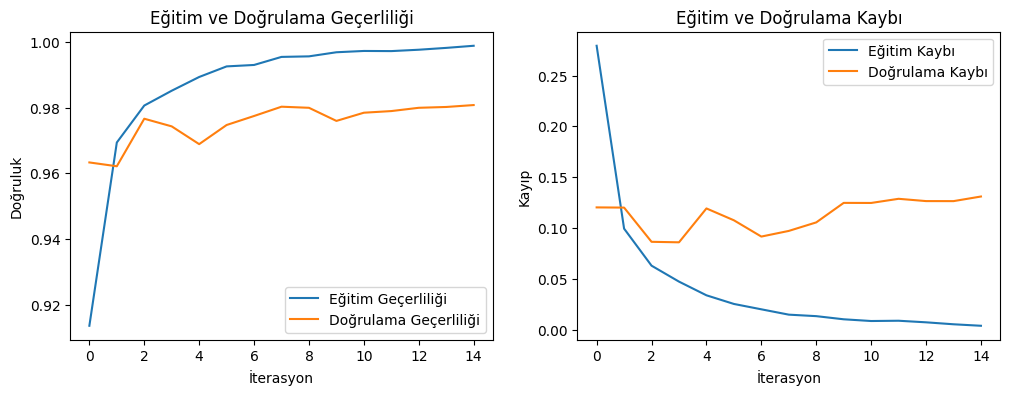

In [10]:
plt.figure(figsize=(12,4))

# Doğruluk grafiği
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Eğitim Geçerliliği')
plt.plot(history.history['val_accuracy'], label='Doğrulama Geçerliliği')
plt.title('Eğitim ve Doğrulama Geçerliliği')
plt.xlabel('İterasyon')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp grafiği
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('İterasyon')
plt.ylabel('Kayıp')
plt.legend()

plt.show()

## 9. Tahminler ve Sonuçlar

Modelin test setindeki bazı örnekler üzerindeki tahminlerini görselleştiriyoruz. Doğru tahminler yeşil, yanlış tahminler kırmızı ile gösterilmiştir.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


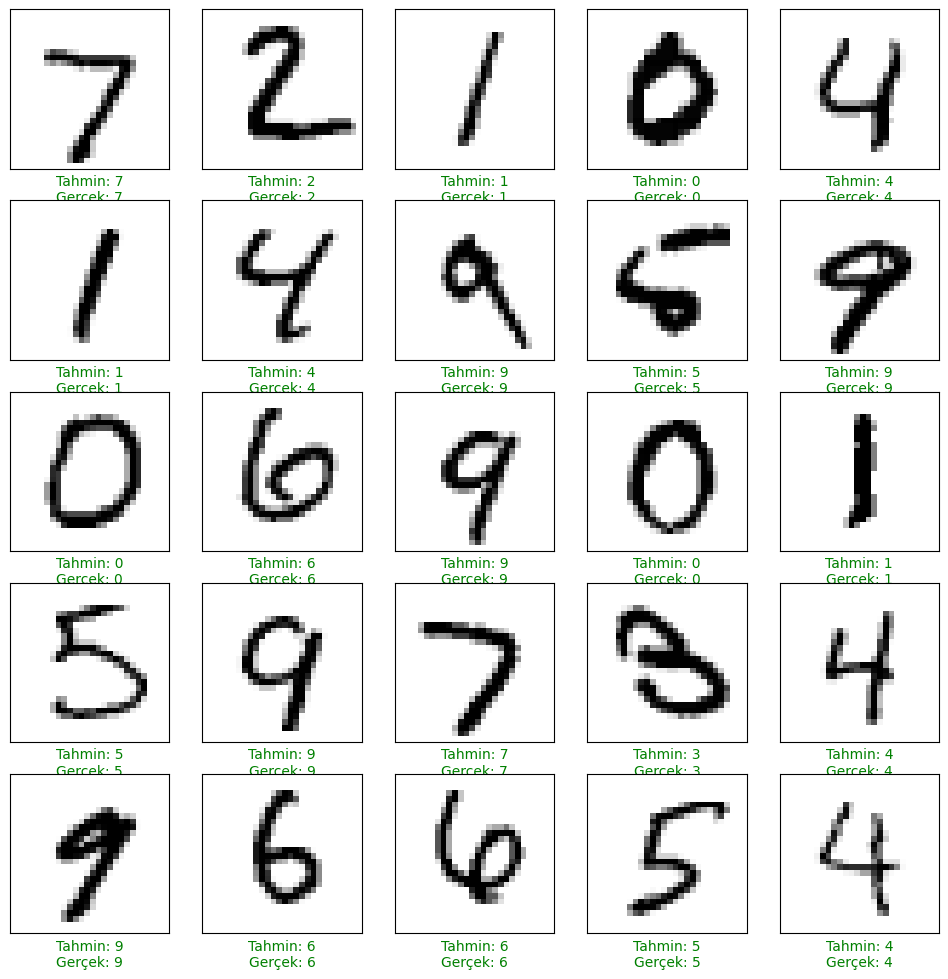

In [11]:
predictions = model.predict(test_images)

plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions[i])
    true_label = np.argmax(test_labels[i])
    color = 'green' if predicted_label == true_label else 'red'
    plt.xlabel(f"Tahmin: {predicted_label}\nGerçek: {true_label}", color=color)
    plt.xticks([])
    plt.yticks([])
plt.show()

## 10. Karışıklık Matrisi ve Detaylı Performans Analizi

Modelin sınıflandırma performansını daha detaylı analiz etmek için bir karışıklık matrisi oluşturuyoruz. Bu bize hangi sınıfların birbirleriyle karıştırıldığını gösterecek.

In [12]:
# Tahminleri ve gerçek etiketleri hazırlama
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

In [13]:
# Karışıklık matrisi hesaplama
cm = confusion_matrix(y_true, y_pred)

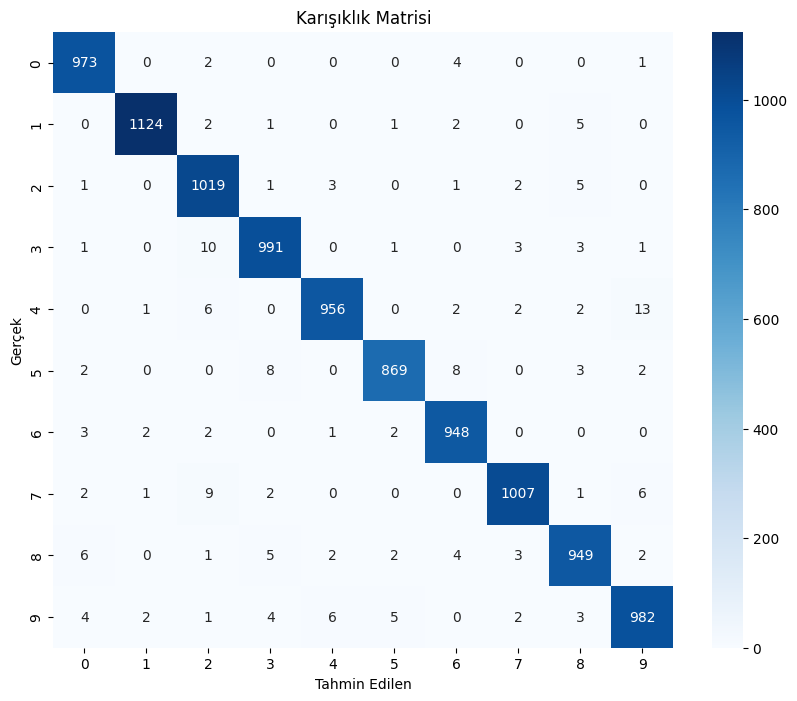

In [14]:
# Karışıklık matrisi görselleştirme
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()

In [15]:
# Sınıflandırma raporu
print("\nSınıflandırma raporu:")
print(classification_report(y_true, y_pred, digits=4))


Sınıflandırma raporu:
              precision    recall  f1-score   support

           0     0.9808    0.9929    0.9868       980
           1     0.9947    0.9903    0.9925      1135
           2     0.9686    0.9874    0.9779      1032
           3     0.9792    0.9812    0.9802      1010
           4     0.9876    0.9735    0.9805       982
           5     0.9875    0.9742    0.9808       892
           6     0.9783    0.9896    0.9839       958
           7     0.9882    0.9796    0.9839      1028
           8     0.9773    0.9743    0.9758       974
           9     0.9752    0.9732    0.9742      1009

    accuracy                         0.9818     10000
   macro avg     0.9818    0.9816    0.9817     10000
weighted avg     0.9819    0.9818    0.9818     10000



## 11. Sonuç ve Değerlendirme

Model, test setinde %98.06 doğruluk elde etti. Karışıklık matrisi analizi bize:

- En yüksek performans 0 ve 1 rakamlarında (F1-score > 0.98)
- En çok karıştırılan rakam çiftleri: 4-9, 5-3, 7-9
- Tüm sınıflarda dengeli bir performans (precision(hassasiyet) ve recall(geri çağırma) değerleri birbirine yakın)

### İyileştirme Önerileri:
1. Yanlış sınıflandırılan örnekler üzerinde odaklanarak veri artırma (augmentation) yapılabilir
2. Karıştırılan rakam çiftleri için özel önlemler alınabilir (örneğin 4 ve 9'u ayırt edecek özellikler)
3. Daha karmaşık mimariler (CNN) denenebilir
4. Öğrenme oranı zamanlaması ile son epoch'lardaki doğrulama kaybı artışı engellenebilir